# **Irene Dovichi** 
## Midterm 1 - Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph, io
from skimage.metrics import structural_similarity
from skimage.filters import threshold_mean, threshold_otsu, threshold_yen
import os
from tqdm import tqdm

## Dataset Loading
All the original images of the Weizmann Horse Database (link: www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data) are saved in the list `images`. 

The corresponding masks are saved in the list `masks`.

In [67]:
path = './weizmann_horse_db/horse'
images = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        images.append(io.imread(os.path.join(path, file)))

In [68]:
path = './weizmann_horse_db/mask'
masks = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        masks.append(io.imread(os.path.join(path, file)))

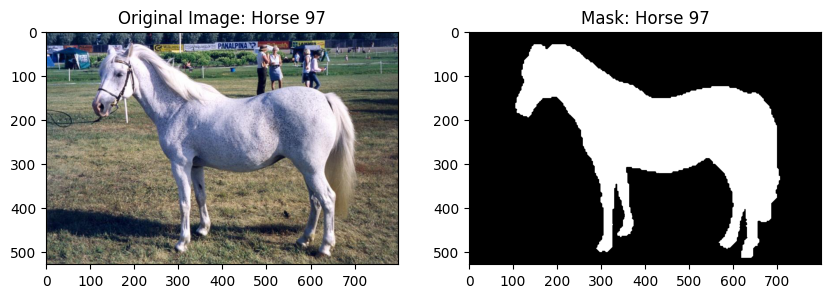

In [48]:
# print element m of `images` and the corresponding element of `masks`
m = 97

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(images[m])
plt.title(f'Original Image: Horse {m}')

plt.subplot(1, 2, 2)
plt.imshow(masks[m], cmap='gray')
plt.title(f'Mask: Horse {m}')
plt.show()

## Segmentation
The skimage implementation of SLIC algorithm was used to generate the superpixels of images. The parameters I focused on were:
- `compactness`, for which I tried the values: 0.01, 0.1, 1, 10
- `sigma`, for which I tried: 0, 1, 10, 100
- `n_parameters`, for which I tried: 100, 500

The best parameter configuration was chosen on the basis of the results obtained comparing the processed images and the masks.

I also tried the zero parameter version SLICO.

In [4]:
"""
# convert images to grayscale
gray_images = [color.rgb2gray(img) for img in images]
"""

In [5]:
# compactness parameters
compactness = [0.01, 0.1, 1, 10]

# sigma parameters
sigma = [0, 1, 10, 100]

# number of segments
n_segments = [100, 500]

I performed the grid search on half of the instances of the dataset (randomly chosen), since it is time consuming.

In [69]:
len(images)

327

In [17]:
# select k random images 
k = 164
np.random.seed(42)
random_indexes = np.random.choice(len(images), k, replace=False)
random_images = []
gray_random_images = []
random_masks = []
for i in random_indexes:
    random_images.append(images[i])
    gray_random_images.append(gray_images[i])
    random_masks.append(masks[i])


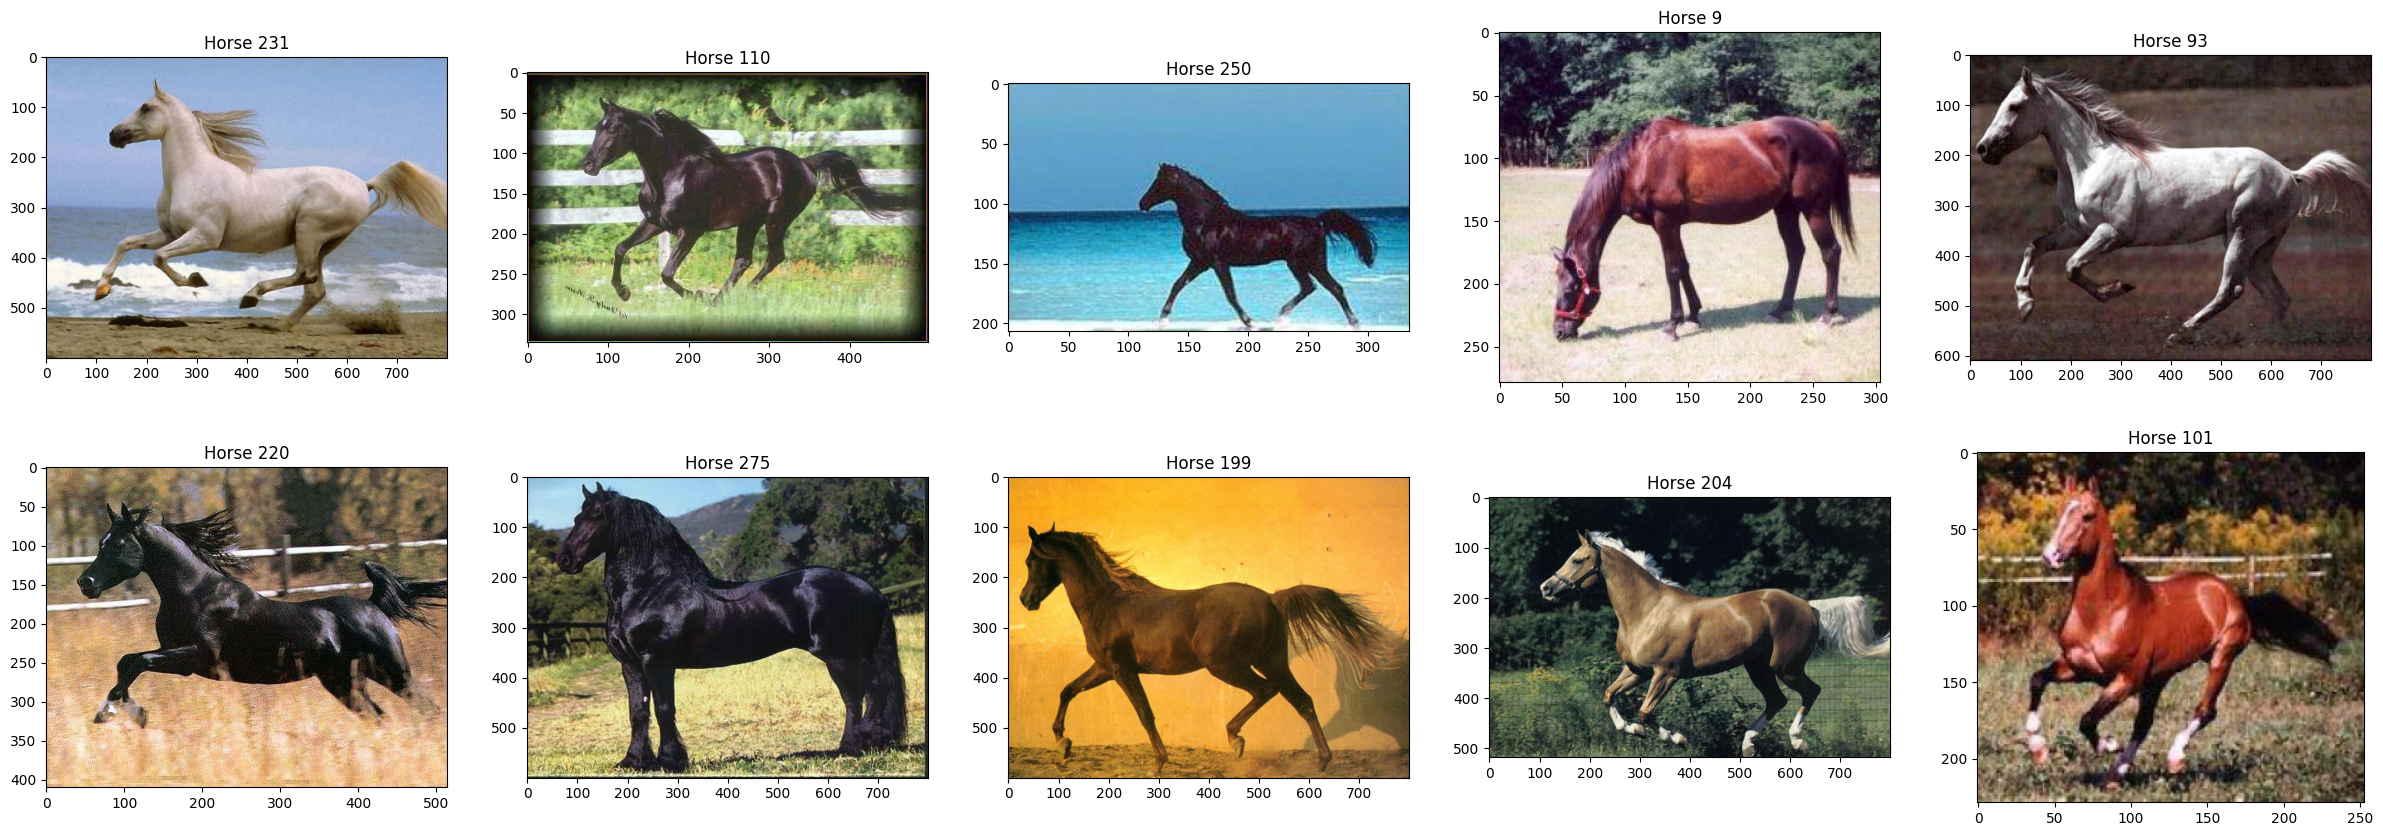

In [18]:
'''# plot the random_images
plt.figure(figsize=(30,10))
for i in range(k):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_images[i])
    plt.title(f'Horse {random_indexes[i]}')'''

In [52]:
'''random_images[0].shape'''

(600, 800, 3)

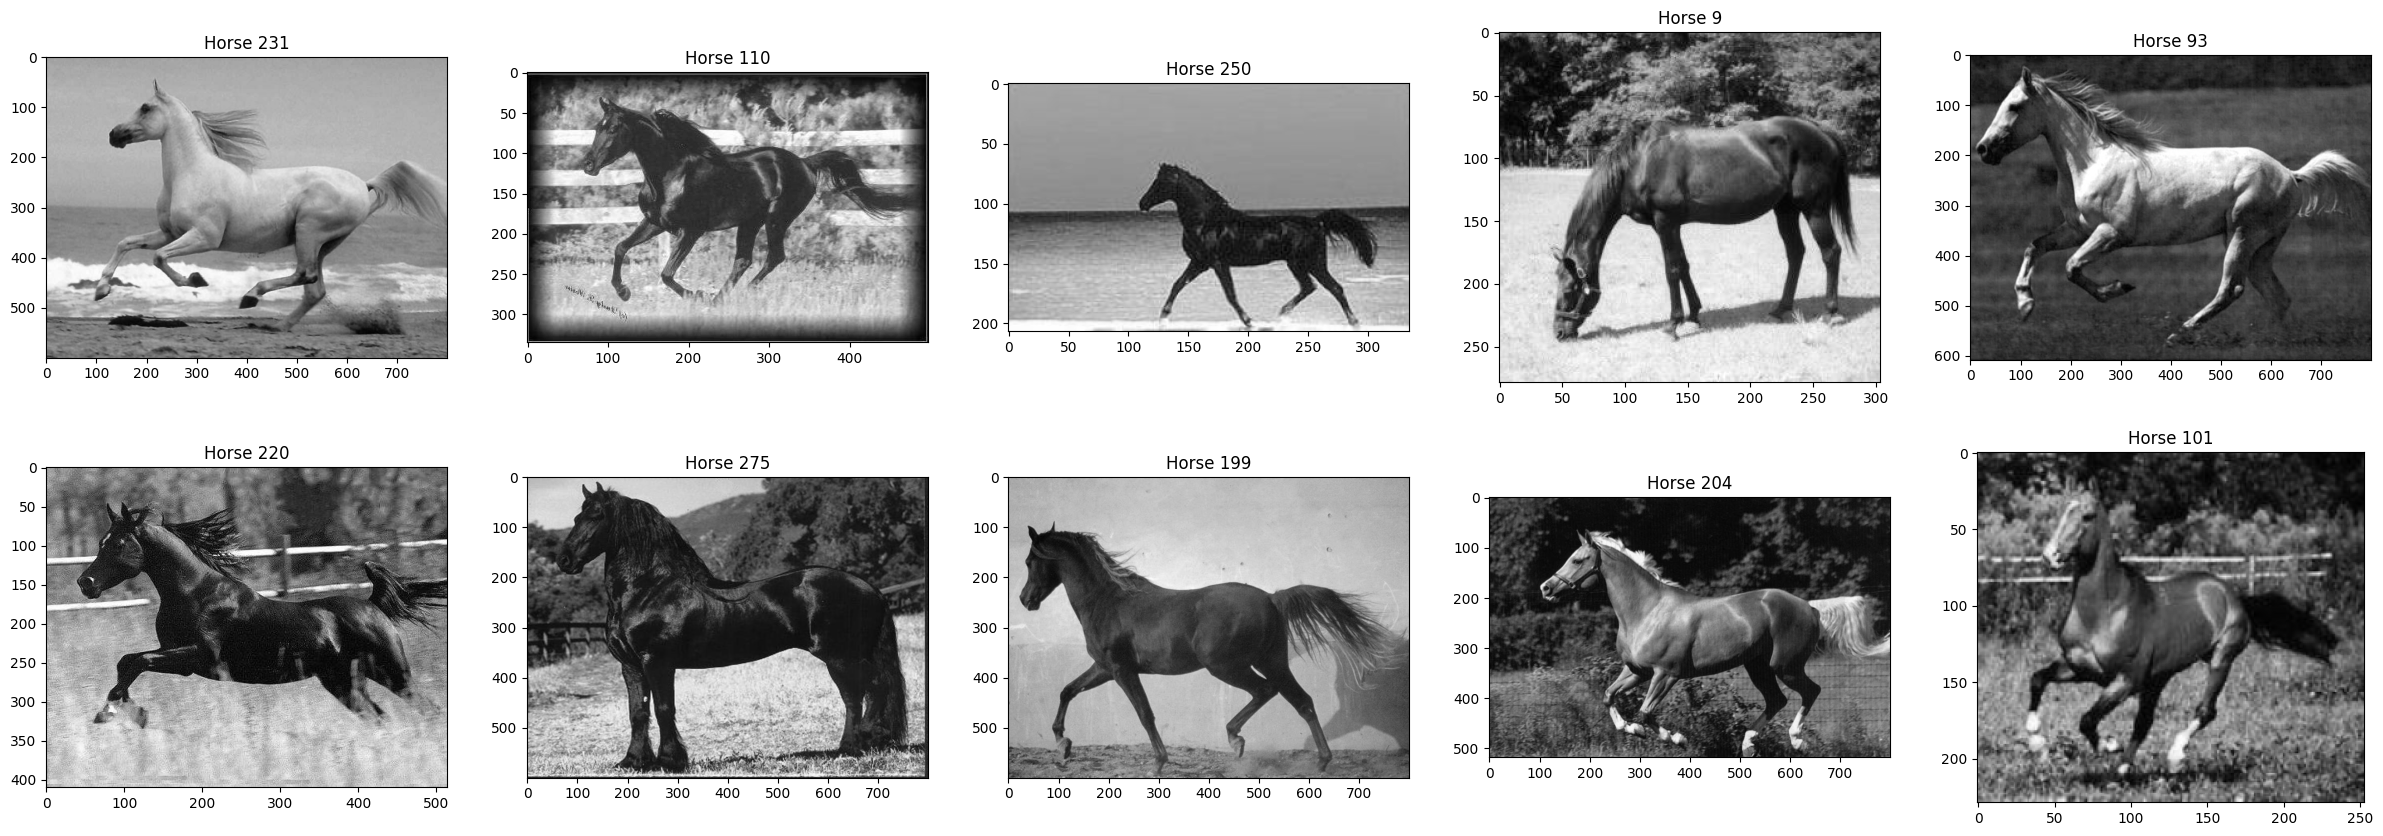

In [54]:
'''# plot the gray_random_images
plt.figure(figsize=(30,10))
for i in range(k):
    plt.subplot(2, 5, i+1)
    plt.imshow(gray_random_images[i], cmap='gray')
    plt.title(f'Horse {random_indexes[i]}')'''

In [50]:
'''gray_random_images[0].shape'''

(600, 800)

In [55]:
"""
apply first grayscale
segmentation_results = []

# apply segmentation and ncut
for i in range(len(gray_random_images)): 
    image_results = []
    for c in compactness:
        for s in sigma:
            for n in n_segments:
                segments = segmentation.slic(gray_random_images[i], compactness=c, n_segments=n, sigma=s, channel_axis=None)
                g = graph.rag_mean_color(gray_random_images[i], segments, mode='similarity')
                cut = graph.cut_normalized(segments, g)
                # store results for this combination of parameters
                image_results.append((c, s, n, segments, cut))
    segmentation_results.append(image_results)
"""

apply segmentation to colored images

In [20]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=32*k, desc='loading', colour='yellow') as pbar:
    for i in range(len(random_images)): 
        image_results = []
        for c in compactness:
            for s in sigma:
                for n in n_segments:
                    segments = segmentation.slic(random_images[i], compactness=c, n_segments=n, sigma=s)
                    g = graph.rag_mean_color(random_images[i], segments, mode='similarity')
                    cut = graph.cut_normalized(segments, g)
                    # store results for this combination of parameters
                    image_results.append((c, s, n, segments, cut))
                    pbar.update(1)
        segmentation_results.append(image_results)

loading: 100%|██████████| 320/320 [08:05<00:00,  1.52s/it]


In [122]:
# for example, the segmentation of the first image, for the first combination of parameters (c,s,n) is:
segmentation_results[0][0][3]

array([[ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       ...,
       [49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48]])

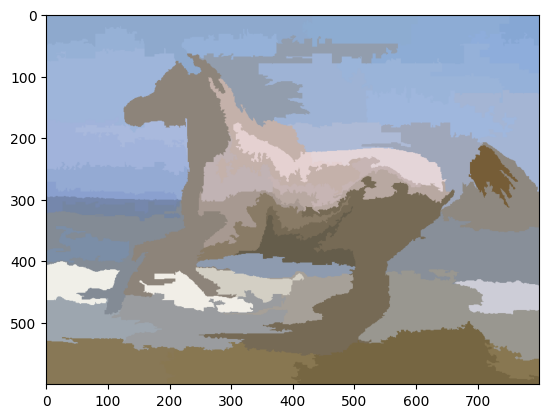

In [8]:
'''# we can also use average of the pixels (in the corresponding superpixel) to color the superpixel
colored = color.label2rgb(segmentation_results[0][0][3], random_images[0], kind='avg')
plt.imshow(colored)'''

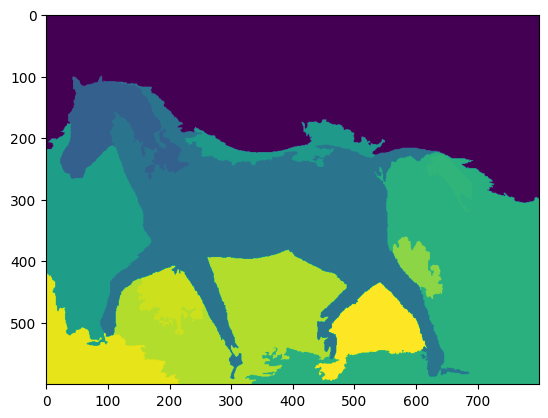

In [9]:
plt.imshow(segmentation_results[7][10][4])

Segmentation accuracy: now let's compare the segmented regions obtained from normalized cut with ground truth segmentation masks. 

The tried metrics are: 
- Intersection over Union $$IoU(A,B) = \frac{|A \cap B|}{|A \cup B|}$$ 
- Structural Similarity Index Measure (SSIM)

at the end, we choose `???` since it gives higher results :)

In [21]:
def IoU(segments, mask):
    intersection = np.logical_and(segments, mask)
    union = np.logical_or(segments, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

Since the comparison is done with the masks, which have only 2 colors, I decided to reduce the cut to a 2-colors image. So, I converted the multi-class segmentation result into a binary mask by thresholding the pixel values. 
1. first, use the labels to create the rgb image
2. switch to grayscale images so it's uniform for all of them
3. use a threshold to split in two: otsu, yen or mean

Let's see on a chosen horse the result of each step, before applying it to all the `random_images`.

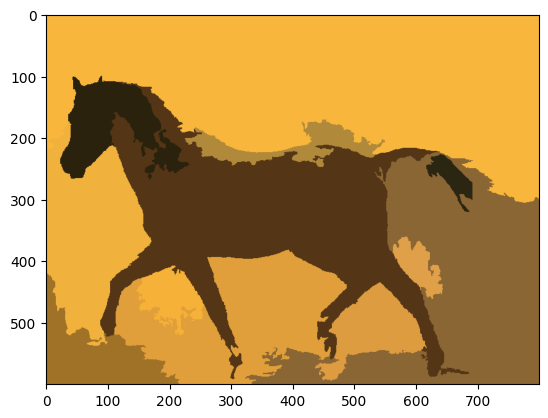

In [39]:
# step 1
ncolored = color.label2rgb(segmentation_results[7][10][4], random_images[7], kind='avg')
plt.imshow(ncolored)

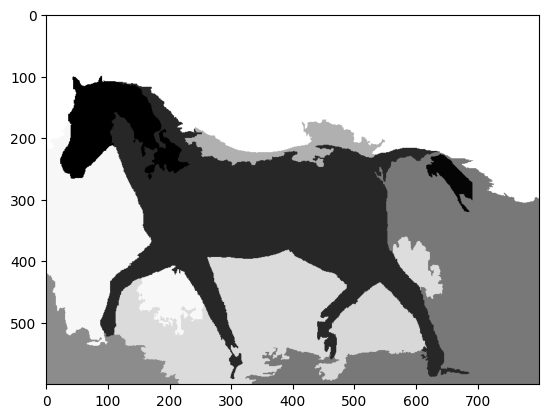

In [40]:
# step 2
gray_image = color.rgb2gray(ncolored)
plt.imshow(gray_image, cmap='gray')

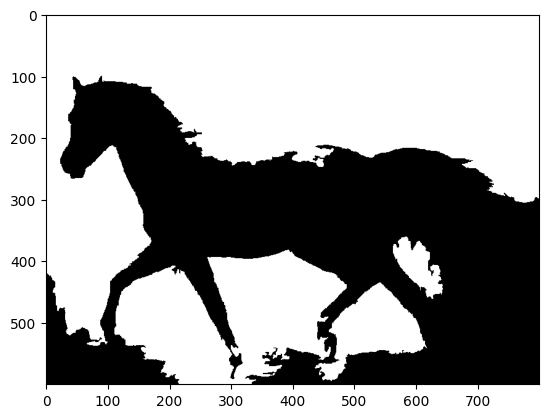

In [41]:
# step 3
# use threshold_mean to create a binary mask
thresh = threshold_mean(gray_image)
thresh_image = gray_image > thresh
plt.imshow(thresh_image, cmap='gray')

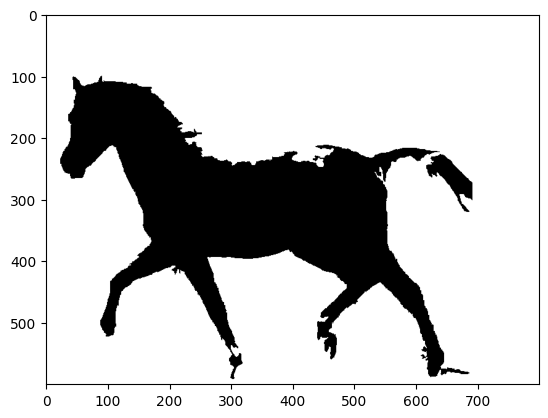

In [42]:
# use threshold_mean to create a binary mask
# DIVIDING BY 2 GIVES BETTER RESULTS IN THIS CASE
thresh = threshold_mean(gray_image)/2
thresh_image = gray_image > thresh
plt.imshow(thresh_image, cmap='gray')

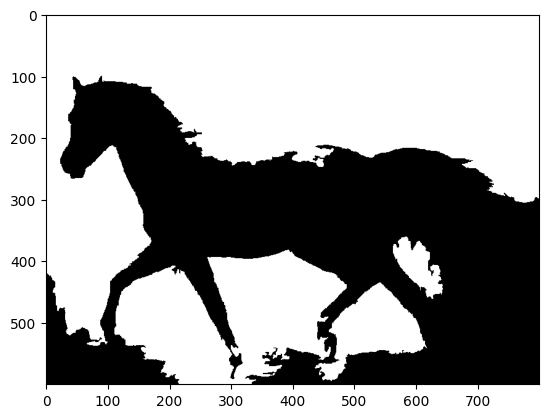

In [43]:
# try otsu 
thresh_otsu = threshold_otsu(gray_image)
thresh_image_otsu = gray_image > thresh_otsu
plt.imshow(thresh_image_otsu, cmap='gray')

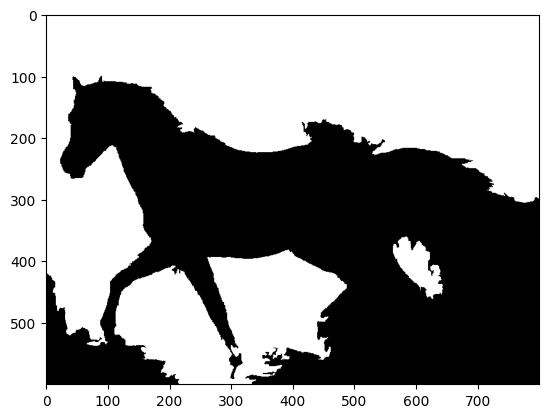

In [44]:
# try yen
thresh_yen = threshold_yen(gray_image)
thresh_image_yen = gray_image > thresh_yen
plt.imshow(thresh_image_yen, cmap='gray')

In [ ]:
#TODO: se per 3/4 cavalli si vede che otsu e yen danno risultati analoghi a mean o mean/2 allora non plottarli nemmeno e citare giusto nelle 
# 'personal considerations'che si sono provate.
# Dare una motivazione del perche fare mean/2 funziona meglio (perlomeno in alcuni casi)
# fare un confronto tra mean/2 e mean per vedere se effettivamente mean/2 funziona meglio

In [46]:
iou = max(IoU(thresh_image, random_masks[7]), IoU(1-thresh_image, random_masks[7]))
iou

0.75994508392961

In [47]:
data_range = 1
ssim = max(
    structural_similarity(thresh_image, random_masks[7], data_range=1),
    structural_similarity(1-thresh_image, random_masks[7], data_range=1)
    )
ssim

0.8786434092638015

In [ ]:
#TODO: se per 4/5 cavalli si vede che ssim e iou danno risultati qualitativamente analoghi usare direttamente ssim (se da' valori piu alti)
# e citare giusto nelle 'personal considerations'che si è provato.

In [132]:
'''#TODO: calculate iou between thresh_images and the corresponding masks
iou_results = []

for image_results in range(len(segmentation_results)):
    iou_image_results = []
    for param in range(len(segmentation_results[image_results])):
        iou = IoU(segmentation_results[image_results][param][3], random_masks[image_results])
        iou_image_results.append(iou)
    iou_results.append(iou_image_results)'''

SSIM

In [151]:
ssim_results = []

for image_results in range(len(segmentation_results)):
    ssim_image_results = []
    for param in range(len(segmentation_results[image_results])):
        data_range = np.max(segmentation_results[image_results][param][3]) - np.min(segmentation_results[image_results][param][3])
        ssim = structural_similarity(
            segmentation_results[image_results][param][3], 
            random_masks[image_results],
            data_range=data_range
            )
        ssim_image_results.append(ssim)
    ssim_results.append(ssim_image_results)

## NOW, choose parameters
on the basis of the performances, choose the parameters configuration

### Zero parameters version
SLICO adaptively chooses the compactness parameter for each superpixel differently. This generates regular shaped superpixels in both textured and non textured regions alike.

In [15]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=k, desc='loading', colour='yellow') as pbar:
    for i in range(len(random_images)): 
        image_results = []
        segments = segmentation.slic(random_images[i], slic_zero=True)
        g = graph.rag_mean_color(random_images[i], segments, mode='similarity')
        cut = graph.cut_normalized(segments, g)
        # store results for this combination of parameters
        image_results.append((segments, cut))
        pbar.update(1)
        segmentation_results.append(image_results)

loading: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


In [16]:
len(segmentation_results)

10

In [20]:
plt.imshow(segmentation_results[0][1])

IndexError: list index out of range

## Valutation

In [ ]:
# for the chosen configuration of parameters, let's perform the segmentation and ncut algorithm on all the images

## Results & Analysis

In [ ]:
# summarizing table

## Personal Considerations

In [ ]:
# fun things, weak aspects, possible ways to enhance the analysis, etc.

# I also tried IoU metric, which qualitavely gives similar results to SSIM, but quantitavily gives lower values (true???)

# I also tried otsu and yen thresholding, but the results are not better than the mean thresholding